# 워드 임베딩(Word Embedding)
- 인공신경망 학습을 통해 단어를 벡터화
- 밀집표현으로 변환 <-> 원핫인코딩(희소표현)

## 워드투벡터(Word2Vec)
단어의 의미를 여러 차원에 분산하여 표현하기 위한 학습방법

### CBOW(Continuous Bag of Words)
- 주변 단어들을 입력으로 중간에 단어를 예측하는 방법
- 윈도우(window): 중심 단어 예측을 위한 주변단어의 개수
- 은닉층이 1개인 신경망, 활성화 함수x, 룩업테이블
![nn](https://wikidocs.net/images/page/22660/word2vec_renew_2.PNG)
=> M: 임베딩 벡터 차원, V: 단어집합 크기\
=> W, W'을 데이터를 통해 학습\
=> W의 각 행벡터가 각 단어의 임베딩 벡터\
=> Projection layer부분에서 각 벡터의 평균 계산\
- 최종적으로 W의 각 행 또는 W와 W'을 이용해 임베딩 벡터를 사용

### Skip-gram
- 중심 단어을 입력으로 주변 단어 예측
- 성능면에서  Skip-gram > CBOW

## 실습

### 영어 Word2Vec 만들기

In [1]:
from pathlib import Path
import re
import urllib.request
import zipfile
from lxml import etree
from nltk.tokenize import word_tokenize, sent_tokenize

## data download
data_dir = Path('C:/Users/sinjy/jupyter_notebook/github/data') / 'english_word2vec'
data_dir.mkdir(exist_ok=True)

urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml", 
                           filename=data_dir / "ted_en-20160408.xml")

(WindowsPath('C:/Users/sinjy/jupyter_notebook/github/data/english_word2vec/ted_en-20160408.xml'),
 <http.client.HTTPMessage at 0x16ad2600988>)

In [2]:
## preprocessing
targetXML = open(data_dir / "ted_en-20160408.xml", 'r', encoding='UTF8')
target_text = etree.parse(targetXML)
parse_text = '\n'.join(target_text.xpath('//content/text()'))
content_text = re.sub(r'\([^)]*\)', '', parse_text)

sent_text = sent_tokenize(content_text)
sent_text

["Here are two reasons companies fail: they only do more of the same, or they only do what's new.",
 'To me the real, real solution to quality growth is figuring out the balance between two activities: exploration and exploitation.',
 'Both are necessary, but it can be too much of a good thing.',
 'Consider Facit.',
 "I'm actually old enough to remember them.",
 'Facit was a fantastic company.',
 'They were born deep in the Swedish forest, and they made the best mechanical calculators in the world.',
 'Everybody used them.',
 'And what did Facit do when the electronic calculator came along?',
 'They continued doing exactly the same.',
 'In six months, they went from maximum revenue ... and they were gone.',
 'Gone.',
 'To me, the irony about the Facit story is hearing about the Facit engineers, who had bought cheap, small electronic calculators in Japan that they used to double-check their calculators.',
 'Facit did too much exploitation.',
 'But exploration can go wild, too.',
 'A few

In [3]:
normalized_text = []
for string in sent_text:
    tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
    normalized_text.append(tokens)

result = [word_tokenize(sentence) for sentence in normalized_text]

In [4]:
len(result)

273380

In [5]:
## training
from gensim.models import Word2Vec, KeyedVectors

model = Word2Vec(sentences=result, vector_size=100, window=5, min_count=5, workers=4, 
                sg=0) # size: 임베딩 벡터차원, sg=0: cbow, sg=1: skip-gram

In [6]:
model_result = model.wv.most_similar('man')
model_result

[('woman', 0.8452582955360413),
 ('guy', 0.8144667148590088),
 ('boy', 0.7754080891609192),
 ('lady', 0.7733100056648254),
 ('girl', 0.751846969127655),
 ('gentleman', 0.7421200275421143),
 ('soldier', 0.7312666177749634),
 ('poet', 0.7121500968933105),
 ('kid', 0.6892486214637756),
 ('david', 0.6553768515586853)]

In [7]:
## save & load
model.wv.save_word2vec_format(data_dir / 'eng_w2v')
loaded_model = KeyedVectors.load_word2vec_format(data_dir / 'eng_w2v')

## 사전 훈련된 Word2Vec 임베딩
데이터 부족할 때 미리 훈련된 임베딩 벡터 사용

## 네거티브 샘플링을 이용한 Word2Vec 구현 (Skip-Gram with Negative Sampling, SGNS)

### 네거티브 샘플링 (Negative Sampling)
학습과정에서 전체 단어 집합이 아니라 일부 단어 집합에만 집중\
마지막 단계를 이진 분류 문제로 변환

### 네거티브 샘플링 Skip-Gram (Skip-Gram with Negative Sampling, SGNS)
- 일반 Skip-Gram: 중심 단어(cat)로부터 주변 단어(sat) 예측
![nn](https://wikidocs.net/images/page/69141/%EA%B7%B8%EB%A6%BC1-1.PNG)


- SGNS: 중심단어와 주변단어를 입력으로 받고 윈도우 크기내에 존재하는 이웃관계인지 그 확률 예측\
1. 중심단어와 주변단어 각각의 임베딩테이블을 만들고 
2. 입력1(중심단어)와 입력2(주변단어)각각의 룩업 임베딩벡터로 변환
3. 두 임베딩 벡터의 내적값을 예측값으로 하여 레이블과의 오차를 구한다.
4. 오차를 이용해 임베딩테이블을 업데이트
5. 중심 단어 임베딩 행렬을 사용하거나 두 행렬을 더하거나 연결하여 사용할수 있다.
![nn](https://wikidocs.net/images/page/69141/%EA%B7%B8%EB%A6%BC1-2.PNG)

### 실습 (20뉴스그룹 데이터, tensorflow)

In [8]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer

In [9]:
## preprocessing
dataset = fetch_20newsgroups(shuffle=True, random_state=1, 
                             remove=('headers', 'footers', 'quotes'))
documents = dataset.data
len(documents)

11314

In [10]:
## 불필요한 토큰 제거, 정규화
news_df = pd.DataFrame({'document': documents})
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

C:\Users\sinjy\anaconda3\envs\machine-learning\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
news_df.isnull().values.any()

False

In [12]:
news_df.replace("", float("NaN"), inplace=True)
news_df.isnull().values.any()

True

In [13]:
news_df.dropna(inplace=True)
len(news_df)

10995

In [14]:
## 불용어 제거
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

In [15]:
## 단어 개수 1개이하인 경우 제거
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
len(tokenized_doc)

C:\Users\sinjy\anaconda3\envs\machine-learning\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


10940

In [16]:
## integer encoding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {value: key for key, value in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [17]:
encoded[:2]

[[9,
  59,
  603,
  207,
  3278,
  1495,
  474,
  702,
  9470,
  13686,
  5533,
  15227,
  702,
  442,
  702,
  70,
  1148,
  1095,
  1036,
  20294,
  984,
  705,
  4294,
  702,
  217,
  207,
  1979,
  15228,
  13686,
  4865,
  4520,
  87,
  1530,
  6,
  52,
  149,
  581,
  661,
  4406,
  4988,
  4866,
  1920,
  755,
  10668,
  1102,
  7837,
  442,
  957,
  10669,
  634,
  51,
  228,
  2669,
  4989,
  178,
  66,
  222,
  4521,
  6066,
  68,
  4295],
 [1026,
  532,
  2,
  60,
  98,
  582,
  107,
  800,
  23,
  79,
  4522,
  333,
  7838,
  864,
  421,
  3825,
  458,
  6488,
  458,
  2700,
  4730,
  333,
  23,
  9,
  4731,
  7262,
  186,
  310,
  146,
  170,
  642,
  1260,
  107,
  33568,
  13,
  985,
  33569,
  33570,
  9471,
  11491]]

In [18]:
vocab_size = len(word2idx) + 1
vocab_size

64277

In [19]:
## generate dataset with negative samping
from tensorflow.keras.preprocessing.sequence import skipgrams
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:10]]

In [20]:
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
    print(pairs[i], labels[i])

[4865, 984] 1
[2669, 442] 1
[702, 25277] 0
[1095, 56367] 0
[474, 9] 1


In [21]:
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]

In [22]:
## SGNS 구현
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

In [23]:
embedding_dim = 100
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embedding_dim)(w_inputs)

c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding = Embedding(vocab_size, embedding_dim)(c_inputs)

In [24]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1, ), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       6427700     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       6427700     input_2[0][0]                    
______________________________________________________________________________________________

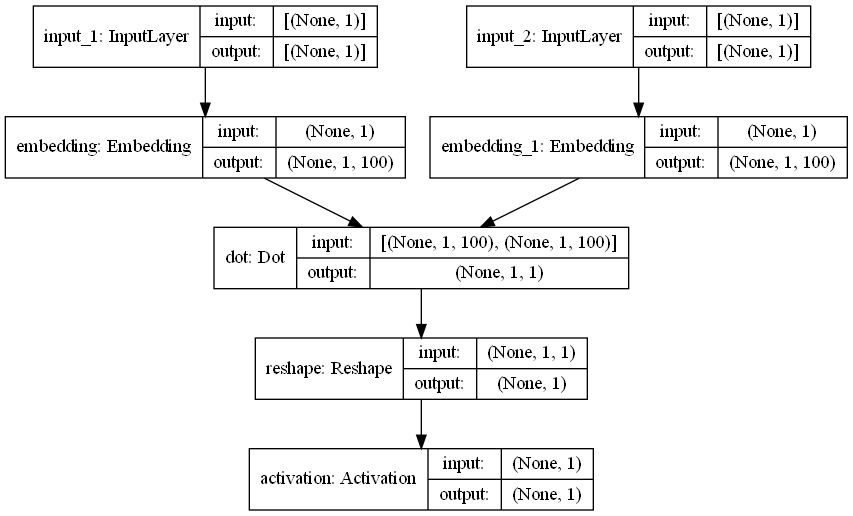

In [25]:
from pathlib import Path
data_dir = Path('C:/Users/sinjy/jupyter_notebook/github/data')
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file=data_dir / 'model3.png', show_shapes=True, show_layer_names=True)

## 글로브 (GloVe)
카운트 기반 LSA와 예측기반 Word2Vec의 단점 보완\
**LSA**: 전체적인 통계정보를 고려하지만 단어 의미 유추작업에는 부족\
**Word2Vec**: 단어 의미 유추작업에 뛰어나지만 윈도우 크기 내에서만 고려하기 때문에 전체적인 통계정보 반영x

### 윈도우 기반 동시 등장 행렬(Window based Co-occurrence Matrix)
matrix[i][k] = i단어의 윈도우 크기 내에서 k단어가 등장한 횟수

### 동시 등장 확률 (Co-occurrence Probability)
$P(k|i)$ 
- 중심단어 i가 등장할 때 주변단어 k가 등장할 확률
- = matrix[i][k] / sum(matrix[i])  (matrix: 동시 등장 행렬)

**임베딩 된 중심 단어와 주변 단어 벡터의 내적이 전체 코퍼스에서 동시 등장 확률이 되도록 만드는 것**

## 패스트텍스트 (FastText)
word2vec의 확장이지만 다른점은 단어 안에도 여러 단어(subword)가 존재한다고 생각함\
apple = <ap + app + ppl + ppl + le> + <app + appl + pple + ple> + <appl + pple> + , ..., +<apple>이런 식으로 분리하고 각 내부단어들을 벡터화하여 합한다\
=> 모르는 단어 (OOV)에 대한 대처 가능, 빈도수 적은 단어의 정확도 향상

## 엘모 (Embeddings from Language Model, ELMo)
사전 훈련된 언어모델 사용\
같은 표기의 단어라도 문맥에 따라서 다르게 워드 임베딩

- 사전 훈련된 biLM 활용\
순방향 언어 모델과 역방향 언어 모델을 각각 학습
![nn](https://wikidocs.net/images/page/33930/playwordvector.PNG)
- 단어에 해당하는 타임의 각층 출력값을 활용한다
1. 각층의 출력값을 연결
2. 각 층의 출력값 별로 가중치를 두어 더한다
![nn](https://wikidocs.net/images/page/33930/weightedsum.PNG)
3. 벡터의 크기를 결정하는 스칼라 매개변수를 곱한다
![nn](https://wikidocs.net/images/page/33930/scalarparameter.PNG)
4. 이렇게 완성한 벡터와 기존 임베딩 벡터를 통해 자연어 처리 작업 수행을 위한 학습
5. 학습 과정에서 각 층 가중치 s와 벡터크기 결정하는 gamma 학습